In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Pre-processing

In [2]:
# all_train = pd.read_csv("datasets/toxic_train.csv")

In [3]:
# filter only toxic comments and convert comment_text to str

# toxic_only_train = all_train[all_train["target"] >= 0.5]
# toxic_only_train['comment_text'] = toxic_only_train['comment_text'].astype(str)

In [4]:
# shortlist only columns of interest only as well

# temp = toxic_only_train.iloc[:, :-13]
# toxic_only_train_shortlisted = temp.drop(temp.columns[[0, 1, 3, 4, 5, 6, 7]], axis = 1)
# toxic_only_train_shortlisted.head()

In [5]:
# assuming that if NaN for any category, probability of category = 0

# toxic_only_train_shortlisted.fillna(0, inplace = True)
# toxic_only_train_shortlisted.head()

In [6]:
# sum values for race, gender, religion and disabilities

# toxic_only_train_shortlisted["Race"] = toxic_only_train_shortlisted[["black", "white", "asian", "latino", "other_race_or_ethnicity"]].sum(axis = 1)
# toxic_only_train_shortlisted["Gender"] = toxic_only_train_shortlisted[["male", "female", "transgender", "other_gender", "heterosexual", "homosexual_gay_or_lesbian", "bisexual", "other_sexual_orientation"]].sum(axis = 1)
# toxic_only_train_shortlisted["Religion"] = toxic_only_train_shortlisted[["christian", "jewish", "muslim", "hindu", "atheist", "other_religion"]].sum(axis = 1)
# toxic_only_train_shortlisted["Disability"] = toxic_only_train_shortlisted[["intellectual_or_learning_disability", "other_disability", "physical_disability", "psychiatric_or_mental_illness"]].sum(axis = 1)

In [7]:
# drop identity columns after

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:25], inplace = True, axis = 1)

In [8]:
# if all identities are 0, we will assume that attacks were not directed to any in particular and hence "None"

# toxic_only_train_shortlisted["target"] = np.where(toxic_only_train_shortlisted.iloc[:, 1:5].max(axis = 1) > 0, toxic_only_train_shortlisted.iloc[:, 1:5].idxmax(axis = 1), "None")

In [9]:
# drop sum columns for all identities

# toxic_only_train_shortlisted.drop(toxic_only_train_shortlisted.iloc[:, 1:5], inplace = True, axis = 1)

In [10]:
# preprocess text
# keep asterisks as they may be used to censor vulgar words

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import nltk
import re

# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocesstext(text):
    text = text.lower() # convert everything to lower case first
    text = re.sub('(?:(?!\*)(?!\*)(?![a-zA-Z0-9]).)', ' ', text) # Removes special characters (except asterisk) and punctuations
    words = word_tokenize(text)
    words_without_stopwords = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    text = " ".join(words_without_stopwords)
    return text

In [11]:
# toxic_only_train_shortlisted["preprocessed_text"] = toxic_only_train_shortlisted["comment_text"].apply(preprocesstext)

In [12]:
# save files so that there's no need to preprocess again

# toxic_only_train_shortlisted.to_pickle('toxic_only_train_shortlisted_preprocessed.pkl')

In [13]:
# load preprocessed file

toxic_only_train_shortlisted = pd.read_pickle('toxic_only_train_shortlisted_preprocessed.pkl')

In [14]:
from sklearn.model_selection import train_test_split

X = toxic_only_train_shortlisted["preprocessed_text"]
y = toxic_only_train_shortlisted["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train)
tfidf_test = tfidf_vec.transform(X_test)

# Classification Models

In [16]:
# install yellowbrick for AUC ROC plot for multiclass

# !pip install yellowbrick

In [17]:
# for evaluation of performance

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
# to facilitate the plotting of ROCAUC curve

from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes=['Race', 'Gender', 'Religion', 'Disability', 'None'])
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

**Logistic Regression**

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
logreg = LogisticRegression(C = 5, random_state = 42, solver = 'sag', max_iter = 1000, n_jobs = -1)
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)

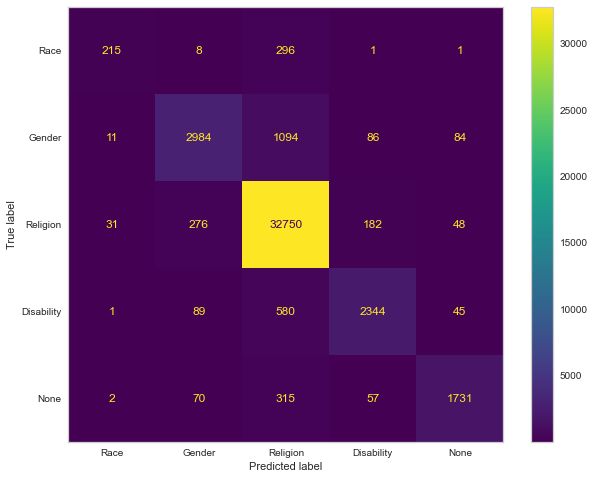

In [21]:
plt.rcParams["figure.figsize"] = (10,8)
mat = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(mat, display_labels=["Race", "Gender", "Religion", "Disability", "None"])
cmd.plot()
plt.tick_params(axis = u'both', which = u'both', length = 0)
plt.grid(b = None)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Disability       0.83      0.41      0.55       521
      Gender       0.87      0.70      0.78      4259
        None       0.93      0.98      0.96     33287
        Race       0.88      0.77      0.82      3059
    Religion       0.91      0.80      0.85      2175

    accuracy                           0.92     43301
   macro avg       0.88      0.73      0.79     43301
weighted avg       0.92      0.92      0.92     43301



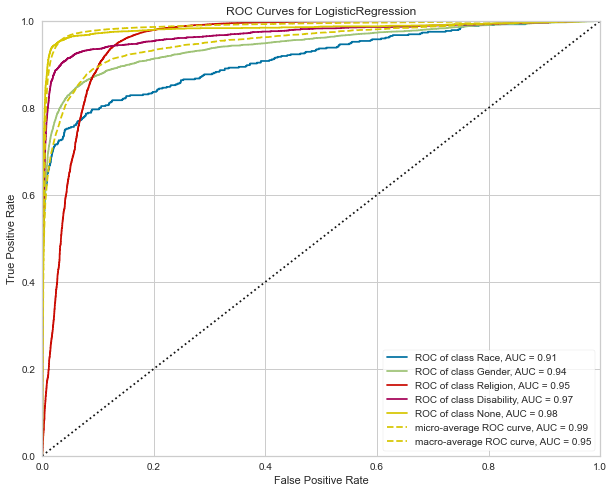

In [23]:
plt.rcParams["figure.figsize"] = (10,8)
plot_ROC_curve(logreg, tfidf_train, y_train, tfidf_test, y_test)
plt.show()